Import

In [1]:
!git clone https://github.com/AndreasHammerKU/CardiacCTAnalysis.git
%cd CardiacCTAnalysis

Cloning into 'CardiacCTAnalysis'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 300 (delta 32), reused 36 (delta 19), pack-reused 223 (from 1)
Receiving objects: 100% (300/300), 1.67 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (158/158), done.
/content/CardiacCTAnalysis


Imports from Github Repository

In [2]:
!pip install dash
import numpy as np

# Custom Imports
import utils.io_utils as io
import utils.logger as logs
from baseline.BaseEnvironment import MedicalImageEnvironment
from utils.io_utils import DataLoader
from baseline.BaseAgent import DQNAgent

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_folder = '/content/drive/MyDrive/Data'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
Mounted at /content/drive


Hyperparameters

In [6]:
MAX_STEPS = 500
EPISODES = 40
IMAGE_INTERVAL = 2
AGENTS = 6
N_SAMPLE_POINTS = 5
EVALUATION_STEPS = 30
DECAY = 200 # EPSILON = MIN_EPS - (MAX_EPS - MIN_EPS) * e^(-1 * current_step / decay)
MODEL_TYPE="CommNet"
ATTENTION=False

In [7]:
debug = False

# Colab not enough RAM
preload_images = False
logger = logs.setup_logger(debug)

dataLoader = DataLoader(dataset_folder)

Training

In [8]:
# Initialize training environment
train_env = MedicalImageEnvironment(logger=logger,
                              dataLoader=dataLoader,
                              image_list=['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30'],
                              agents=AGENTS,
                              n_sample_points=N_SAMPLE_POINTS,
                              preload_images=preload_images)
eval_env = MedicalImageEnvironment(logger=logger,
                              task="eval",
                              dataLoader=dataLoader,
                              image_list=['n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39', 'n40'],
                              agents=AGENTS,
                              n_sample_points=N_SAMPLE_POINTS)
agent = DQNAgent(train_environment=train_env,
                 eval_environment=eval_env,
                 task="train",
                 logger=logger,
                 state_dim=train_env.state_size,
                 action_dim=train_env.n_actions,
                 attention=ATTENTION,
                 model_type=MODEL_TYPE,
                 agents=AGENTS,
                 max_steps=MAX_STEPS,
                 episodes=EPISODES,
                 decay=DECAY,
                 image_interval=IMAGE_INTERVAL,
                 evaluation_steps=EVALUATION_STEPS)

agent.train_dqn()

INFO:Logger:Episode 1: Total Reward = 20.82 | Final Avg Distance 9.19 | All Reached Goal False | Avg Closest Point = 3.14 | Avg Furthest Point = 35.86
INFO:Logger:Episode 2: Total Reward = 25.76 | Final Avg Distance 4.26 | All Reached Goal False | Avg Closest Point = 0.87 | Avg Furthest Point = 34.92
INFO:Logger:Episode 3: Total Reward = 16.55 | Final Avg Distance 7.99 | All Reached Goal False | Avg Closest Point = 1.56 | Avg Furthest Point = 31.90
INFO:Logger:Episode 4: Total Reward = 23.07 | Final Avg Distance 1.46 | All Reached Goal False | Avg Closest Point = 0.00 | Avg Furthest Point = 29.26
INFO:Logger:Episode 5: Total Reward = 30.68 | Final Avg Distance 3.00 | All Reached Goal False | Avg Closest Point = 0.71 | Avg Furthest Point = 35.97
INFO:Logger:Episode 6: Total Reward = 32.17 | Final Avg Distance 1.51 | All Reached Goal False | Avg Closest Point = 0.00 | Avg Furthest Point = 34.80
INFO:Logger:Episode 7: Total Reward = 20.12 | Final Avg Distance 3.34 | All Reached Goal False

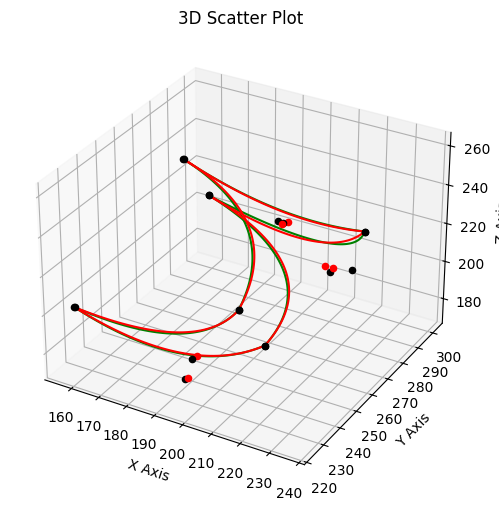

In [9]:
train_env.visualize_current_state()

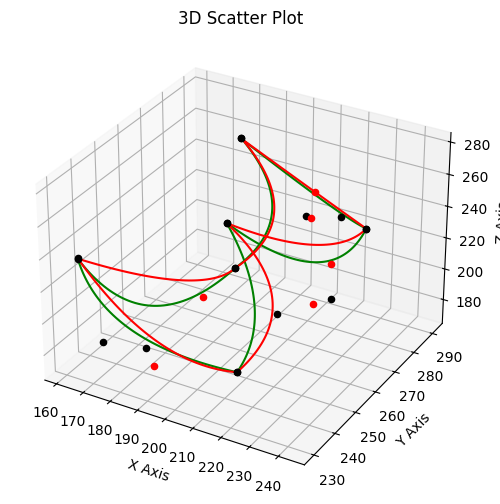

In [10]:
eval_env.visualize_current_state()

Evaluate

In [11]:
test_env = MedicalImageEnvironment(logger=logger,
                              task="test",
                              dataLoader=dataLoader,
                              image_list=['n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49', 'n50'],
                              agents=AGENTS,
                              n_sample_points=N_SAMPLE_POINTS)
agent = DQNAgent(train_environment=train_env,
                 eval_environment=eval_env,
                 test_environment=test_env,
                 task="test",
                 logger=logger,
                 state_dim=test_env.state_size,
                 action_dim=test_env.n_actions,
                 attention=ATTENTION,
                 agents=AGENTS,
                 model_path=f"latest-model-{MODEL_TYPE}.pt",
                 model_type=MODEL_TYPE,
                 max_steps=MAX_STEPS,
                 episodes=EPISODES,
                 evaluation_steps=25
                 )

agent.test_dqn()

/content/CardiacCTAnalysis/baseline/BaseAgent.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_net.load_state_dict(torch.load(model_path, map_location=self.d

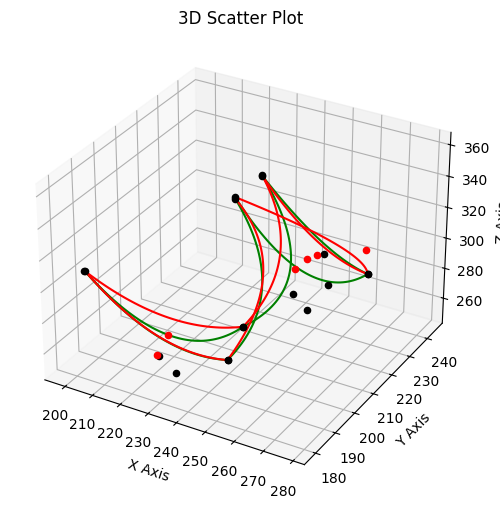

In [12]:
test_env.visualize_current_state()